## Download pre-processed images

[iafoss](https://www.kaggle.com/iafoss/hubmap-256x256)

In [1]:
trainImages := "data/image/256/train"
maskImages := "data/image/256/mask"

In [2]:
import(
    "os"
    "io/ioutil"
    "fmt"
)

In [3]:
func readImage(filename string) []byte {
    
    f, err := os.Open(filename)
    if err != nil {fmt.Print(err)}
    defer f.Close()
    
    buf, err := ioutil.ReadAll(f)
    if err != nil {fmt.Print(err)}
    
    return buf
}

In [157]:
import (
    "bytes"
    "image"
    "image/draw"
    "image/png"
    "os"
)

// ImageData holds infor to draw image on canvas
type ImageData struct {
    Rec        image.Rectangle
    Src        image.Image
    StartPoint image.Point
}

func concatImages(imgFiles []string, padding int) ([]byte, error) {
    var data []ImageData
    var lastX int = 0

    for i := 0; i < len(imgFiles); i++ {
        f, err := os.Open(imgFiles[i])
        if err != nil {
            return nil, err
        }

        img, _, err := image.Decode(f)
        if err != nil {
            return nil, err
        }

        var imgData ImageData
        sp := image.Point{lastX, 0}
        rec := img.Bounds().Add(image.Point{lastX, 0})

        data = append(data, ImageData{
            Rec:        rec,
            Src:        img,
            StartPoint: image.Point{padding, 0},
        })

        lastX = lastX + img.Bounds().Dx() + padding
        f.Close()
    }

    //rectangle for the merged image
    lastPoint := data[len(data)-1].Rec.Max
    r := image.Rectangle{image.Point{0, 0}, lastPoint}

    dstImage := image.NewRGBA(r)

    // start drawing
    for i, d := range data {
        draw.Draw(dstImage, d.Rec, d.Src , image.Point{}, draw.Src)
    }

    buffer := new(bytes.Buffer)
    err := png.Encode(buffer, dstImage)
    if err != nil {
        return nil, err
    }

    return buffer.Bytes(), nil
}


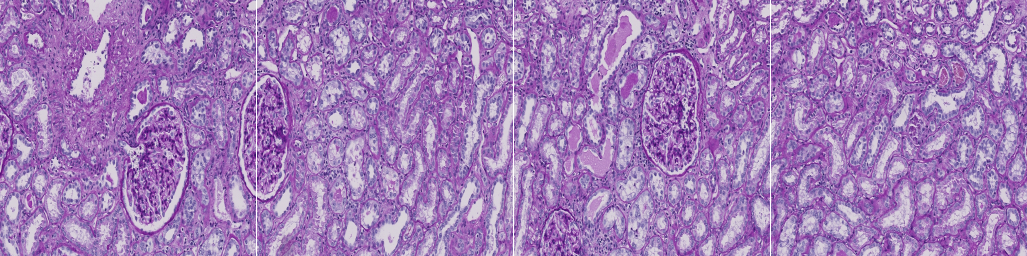

In [158]:
images := []string{
    "data/image/256/train/0486052bb_120.png",
    "data/image/256/train/0486052bb_121.png",
    "data/image/256/train/0486052bb_122.png",
    "data/image/256/train/0486052bb_123.png",
}

buf, err := concatImages(images, 1)
if err != nil { fmt.Print(err)}
display.PNG(buf)

In [178]:
import(
    "os"
    "bytes"
    
    "github.com/go-gota/gota/dataframe"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/vg"
)

f, err := os.Open("data/HuBMAP-20-dataset_information.csv")
if err != nil {fmt.Print(err)}

df := dataframe.ReadCSV(f, dataframe.HasHeader(true))

sub := df.Subset([]int{0, 1, 2})

fmt.Println(sub)

fields := df.Names()
for i, f := range fields{
    fmt.Println(i, f)
}

[3x16] DataFrame

    image_file     width_pixels height_pixels ...
 0: afa5e8098.tiff 43780        36800         ...
 1: 54f2eec69.tiff 22240        30440         ...
 2: 1e2425f28.tiff 32220        26780         ...
    <string>       <int>        <int>         ...

Not Showing: anatomical_structures_segmention_file <string>,
glomerulus_segmentation_file <string>, patient_number <int>, race <string>, ethnicity <string>, sex <string>,
age <int>, weight_kilograms <float>, height_centimeters <float>, bmi_kg/m^2 <float>,
laterality <string>, percent_cortex <int>, percent_medulla <int>

0 image_file
1 width_pixels
2 height_pixels
3 anatomical_structures_segmention_file
4 glomerulus_segmentation_file
5 patient_number
6 race
7 ethnicity
8 sex
9 age
10 weight_kilograms
11 height_centimeters
12 bmi_kg/m^2
13 laterality
14 percent_cortex
15 percent_medulla


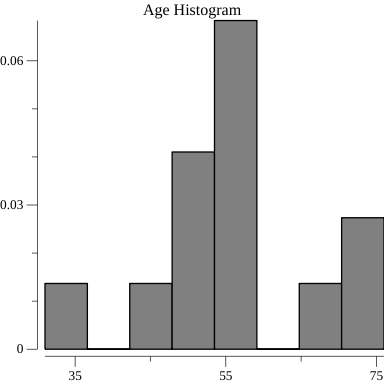

In [183]:
age := df.Col("age").Float()
if err != nil{fmt.Print(err)}

v := make(plotter.Values, len(age))

for i := 0; i < len(age); i++{
    v[i] = age[i]
}

// make a plot and set title
p, err := plot.New()
p.Title.Text = "Age Histogram"
h, err := plotter.NewHist(v, 6)
if err != nil { fmt.Print(err)}
h.Normalize(1)
p.Add(h)


w, err := p.WriterTo(4*vg.Inch, 4*vg.Inch, "png")
if err != nil {
    panic(err)
}

buf := new(bytes.Buffer)
_, err = w.WriteTo(buf)
if err != nil {fmt.Print(err)}

display.PNG(buf.Bytes())